In [93]:
import torch.optim as optim
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import numpy as np
import gzip

In [94]:
torch.manual_seed(42)

In [95]:
import torch
torch.cuda.empty_cache()

Load Dataset

In [96]:
def training_images():
    with gzip.open('/content/train-images-idx3-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def training_labels():
    with gzip.open('/content/train-labels-idx1-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [97]:
x_train = training_images()
x_train.shape

(60000, 28, 28)

In [98]:
y_train = training_labels()
y_train.shape

(60000,)

Display an example

4


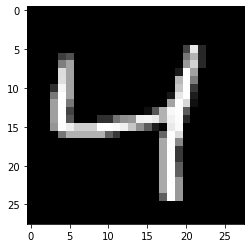

In [99]:
from matplotlib import pyplot as plt
image = x_train[2]
print(y_train[2])
plt.imshow(image, cmap='gray')
plt.show()


In [100]:
x_train = x_train.reshape(60000,1, 28, 28)
x_train.shape

(60000, 1, 28, 28)

In [101]:
x_s=torch.tensor(x_train).type(torch.FloatTensor)
y_s=torch.tensor(y_train)

In [102]:
x_y_concat = zip(x_s,y_s)

In [103]:
x_y_concat = list(x_y_concat)
x_y_concat[1][1]

tensor(0, dtype=torch.uint8)

In [104]:
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
trainDataLoader = DataLoader(x_y_concat, shuffle=True,batch_size=batch_size)
trainSteps = len(trainDataLoader.dataset) // batch_size

Convolutional Neural Network

In [106]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.conv1_bn=nn.BatchNorm2d(32)
        self.max_pool2d = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv2_bn=nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.conv3_bn=nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(576, 128)
        self.fc2 = nn.Linear(128, 10)

        self.logSoftmax = torch.nn.LogSoftmax(dim=1)

      
    def forward(self, x):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv1_bn(x)
        x = self.max_pool2d(x) 
 
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv2_bn(x)
        x = self.max_pool2d(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv3_bn(x)
        x = self.max_pool2d(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x) 
        x = self.fc2(x)
        x = self.logSoftmax(x)

        return x

**PGD Attack- Non targeted**

In [107]:
def PGD_Attack(x,y,model,eta,alfa,steps):
  """
  x = input samples
  y = true labels 
  model = neural network
  eta =  perturbation radius
  alfa = step size 
  steps = number of steps for gradient descent
  """
  random = np.random.uniform(-eta,eta,(1,28,28))
  noise = torch.tensor(random)
  noise = noise.type(torch.LongTensor)
  noise = noise.to(device)
  
  x_hat = x + noise

  for step in range (0,steps):

    x_hat = torch.tensor(x_hat,requires_grad=True)

    pred = model(x_hat)
    loss = lossFn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    d_x = x_hat.grad

    #update x
    z = x_hat + (alfa*torch.sign(d_x))
    #project z
    max = torch.maximum(z, x-eta) 
    x_new = torch.minimum(max, x+eta)

    x_hat = x_new


  return x_hat



**PGD Attack- targeted**

In [108]:
def PGD_AttackTarget(x,y,model,eta,alfa,steps):
  """
  x = input samples
  y = labels 
  model = neural network
  eta =  perturbation radius
  alfa = step size 
  steps = number of steps for gradient descent
  """

  out = model(x)
  for i in range(len(y)):
    a = out.argmax(1)
    out[i][a]=0
  labels = out.argmax(1)

  random = np.random.uniform(-eta,eta,(1,28,28))
  noise = torch.tensor(random)
  noise = noise.type(torch.LongTensor)
  noise = noise.to(device)
  
  x_hat = x + noise

  for step in range (0,steps):

    x_hat = torch.tensor(x_hat,requires_grad=True)

    pred = model(x_hat)
    loss = lossFn(pred, labels)

    optimizer.zero_grad()
    loss.backward()
    d_x = x_hat.grad

    #update x
    z = x_hat - (alfa*torch.sign(d_x))
    #project z
    max = torch.maximum(z, x-eta) 
    x_new = torch.minimum(max, x+eta)

    x_hat = x_new


  return x_hat



In [109]:
torch.cuda.is_available()

True

In [110]:
def train(trainDataLoader,model_CNN,n_epochs,state,eta,alfa,steps):
  """
  xtrainDataLoader = combine of images and labels for a batch
  model_CNN = neural network
  state = 0 for non targetted / 1 for targetted
  eta =  perturbation radius
  alfa = step size 
  steps = number of steps for gradient descent
  """
  train_counter = []
  TrainLoss = []
  TrainLoss_un = []
  trainCorrectAll=[]
  trainCorrectAll_un=[]

  for e in range(0, n_epochs):
  
    model_CNN.train()
    trainCorrect = 0
    trainCorrect_un = 0
    totalTrainLoss = 0
    totalTrainLoss_un = 0

    print(f"epoch= {e}")
    for (x, y) in trainDataLoader:

		  # send the input to the device
      (x, y) = (x.to(device), y.to(device))
    
      #PGD attack
      if state ==0:
         x_attack = PGD_Attack(x,y,model_CNN,eta,alfa,steps)
      else:
         x_attack = PGD_AttackTarget(x,y,model_CNN,eta,alfa,steps)
   
      
      # Loss & accuracy for unperturbed data
      prediction = model_CNN(x)
      loss_N = lossFn(prediction, y)
      totalTrainLoss_un += float(loss_N)
      trainCorrect_un += (prediction.argmax(1) == y).type(
    	  torch.float).sum().item()

      # Loss & accuracy for perturbed data
      pred = model_CNN(x_attack)
      loss = lossFn(pred, y)
	
      opt.zero_grad()
      loss.backward()
      opt.step()
		
      totalTrainLoss +=float(loss)
      trainCorrect += (pred.argmax(1) == y).type(
    	  torch.float).sum().item()
     
    
     
    train_counter.append(e)
    trainCorrectAll.append(trainCorrect/60000)
    trainCorrectAll_un.append(trainCorrect_un/60000)
    TrainLoss.append(totalTrainLoss)
    TrainLoss_un.append(totalTrainLoss_un)

  return(train_counter,trainCorrectAll,trainCorrectAll_un,TrainLoss,TrainLoss_un)
  	

**Classifier 1**

In [111]:
#Setting of paratemers for PGD 
learning_rate = 0.001
model_CNN = CNN().to(device)
optimizer = torch.optim.SGD(model_CNN.parameters(), lr=learning_rate)
lossFn = nn.NLLLoss()
 


In [112]:
#Setting of parameters for training
n_epochs = 10 
learning_rate = 0.001

opt = Adam(model_CNN.parameters(), lr= learning_rate)



In [113]:
train_counter,trainCorrectAll,trainCorrectAll_un,TrainLoss,TrainLoss_un = train(trainDataLoader,model_CNN,n_epochs,0,0.3,0.02,20)

epoch= 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch= 1
epoch= 2
epoch= 3
epoch= 4
epoch= 5
epoch= 6
epoch= 7
epoch= 8
epoch= 9


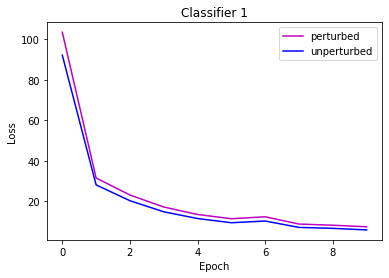

In [114]:
import matplotlib.pyplot as plt

plt.plot(train_counter,TrainLoss,color='m',label='perturbed')
plt.plot(train_counter,TrainLoss_un, color='b',label='unperturbed')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classifier 1')
plt.legend()
plt.show()

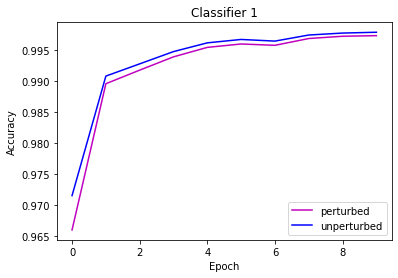

In [115]:
plt.plot(train_counter,trainCorrectAll, color='m',label='perturbed')
plt.plot(train_counter,trainCorrectAll_un, color='b',label='unperturbed')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classifier 1')
plt.legend()
plt.show()

In [72]:
# calculate the training accuracy and loss for perturbed and unperturbed
accuracy = trainCorrectAll[len(trainCorrectAll)-1] 
accuracy_un = trainCorrectAll_un[len(trainCorrectAll_un)-1]
print("EPOCH: {}".format( n_epochs))
print("Train accuracy-perturbed: {:.4f}, Train accuracy-unperturbed: {:.4f}".format(
		accuracy,accuracy_un))
print("loss-perturbed: {:.4f}, Train loss-unperturbed: {:.4f}".format(
		TrainLoss[len(TrainLoss)-1], TrainLoss_un[len(TrainLoss_un)-1]))


EPOCH: 10
Train accuracy-perturbed: 0.9980, Train accuracy-unperturbed: 0.9984
loss-perturbed: 5.9099, Train loss-unperturbed: 4.6999


**Classifier 2**

In [73]:
learning_rate = 0.001
model_CNN2 = CNN().to(device)
optimizer = torch.optim.SGD(model_CNN2.parameters(), lr=learning_rate)
lossFn = nn.NLLLoss()

In [74]:
n_epochs = 10 
learning_rate = 0.001

opt = Adam(model_CNN2.parameters(), lr= learning_rate)
lossFn = nn.NLLLoss()


In [75]:
train_counter,trainCorrectAll,trainCorrectAll_un,TrainLoss,TrainLoss_un = train(trainDataLoader,model_CNN2,n_epochs,0,0.3,0.5,1)

epoch= 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch= 1
epoch= 2
epoch= 3
epoch= 4
epoch= 5
epoch= 6
epoch= 7
epoch= 8
epoch= 9


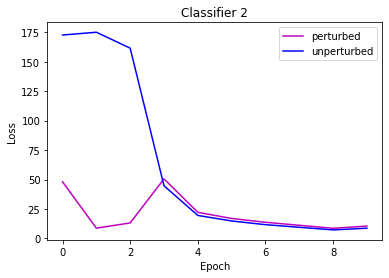

In [76]:
import matplotlib.pyplot as plt
plt.plot(train_counter,TrainLoss, color='m',label='perturbed')
plt.plot(train_counter,TrainLoss_un, color='b',label='unperturbed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classifier 2')
plt.legend()
plt.show()

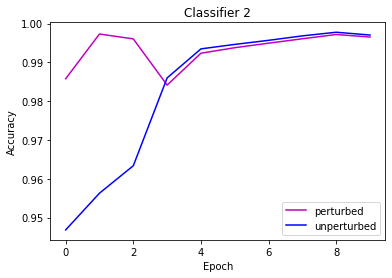

In [77]:
plt.plot(train_counter,trainCorrectAll, color='m',label='perturbed')
plt.plot(train_counter,trainCorrectAll_un, color='b',label='unperturbed')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classifier 2')
plt.legend()
plt.show()

In [78]:
# calculate the training accuracy and loss for perturbed and unperturbed
accuracy = trainCorrectAll[len(trainCorrectAll)-1] 
accuracy_un = trainCorrectAll_un[len(trainCorrectAll_un)-1]
print("EPOCH: {}".format( n_epochs))
print("Train accuracy-perturbed: {:.4f}, Train accuracy-unperturbed: {:.4f}".format(
		accuracy,accuracy_un))
print("loss-perturbed: {:.4f}, Train loss-unperturbed: {:.4f}".format(
		TrainLoss[len(TrainLoss)-1], TrainLoss_un[len(TrainLoss_un)-1]))


EPOCH: 10
Train accuracy-perturbed: 0.9965, Train accuracy-unperturbed: 0.9970
loss-perturbed: 10.4764, Train loss-unperturbed: 8.6654


**Classifier 3**

In [116]:
learning_rate = 0.001
model_CNN3 = CNN().to(device)
optimizer = torch.optim.SGD(model_CNN3.parameters(), lr=learning_rate)
lossFn = nn.NLLLoss()

In [117]:
n_epochs = 10 
learning_rate = 0.001

opt = Adam(model_CNN3.parameters(), lr= learning_rate)
lossFn = nn.NLLLoss()


In [118]:
train_counter,trainCorrectAll,trainCorrectAll_un,TrainLoss,TrainLoss_un = train(trainDataLoader,model_CNN3,n_epochs,1,0.3,0.02,20)

epoch= 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch= 1
epoch= 2
epoch= 3
epoch= 4
epoch= 5
epoch= 6
epoch= 7
epoch= 8
epoch= 9


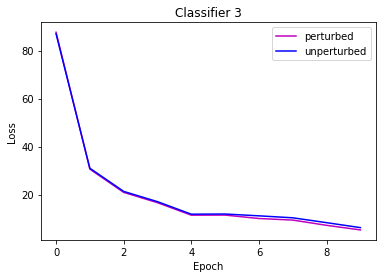

In [119]:
import matplotlib.pyplot as plt
plt.plot(train_counter,TrainLoss, color='m',label='perturbed')
plt.plot(train_counter,TrainLoss_un, color='b',label='unperturbed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classifier 3')
plt.legend()
plt.show()

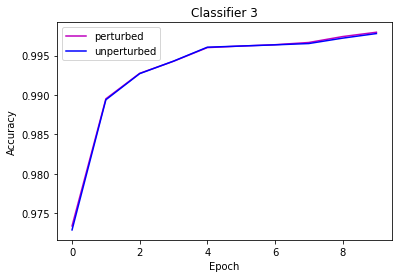

In [120]:
plt.plot(train_counter,trainCorrectAll, color='m',label='perturbed')
plt.plot(train_counter,trainCorrectAll_un, color='b',label='unperturbed')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classifier 3')
plt.legend()
plt.show()

In [121]:
# calculate the training accuracy and loss for perturbed and unperturbed
accuracy = trainCorrectAll[len(trainCorrectAll)-1] 
accuracy_un = trainCorrectAll_un[len(trainCorrectAll_un)-1]
print("EPOCH: {}".format( n_epochs))
print("Train accuracy-perturbed: {:.4f}, Train accuracy-unperturbed: {:.4f}".format(
		accuracy,accuracy_un))
print("loss-perturbed: {:.4f}, Train loss-unperturbed: {:.4f}".format(
		TrainLoss[len(TrainLoss)-1], TrainLoss_un[len(TrainLoss_un)-1]))


EPOCH: 10
Train accuracy-perturbed: 0.9980, Train accuracy-unperturbed: 0.9978
loss-perturbed: 5.2708, Train loss-unperturbed: 6.2239


## **Evaluation**

In [122]:
def testing_images():
    with gzip.open('/content/t10k-images-idx3-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def testing_labels():
    with gzip.open('/content/t10k-labels-idx1-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [123]:
x_test = testing_images()
x_test.shape

(10000, 28, 28)

In [124]:
y_test = testing_labels()
y_test.shape

(10000,)

In [125]:
x_st = x_test.reshape(10000,1,28,28)


In [126]:
x_st = torch.tensor(x_st).type(torch.FloatTensor)
x_st = x_st.to(device)
y_st = torch.tensor(y_test)
y_st = y_st.to(device)

In [127]:
def test(x,y,model,state,eta):
  '''
  x = test images
  y = test labels
  state = 0 for non targetted / 1 for targetted
  eta =  perturbation radius
  '''

  model.eval()

  testCorrect = 0
  show = []

  if state ==0:
      x_attack = PGD_Attack(x,y,model,eta,0.01,40)
  else:
      x_attack = PGD_AttackTarget(x,y,model,eta,0.01,40)

  output = model(x_attack)

  show.append(x_attack[0])
  show.append(x_attack[1])
  
  testCorrect += (output.argmax(1) == y).type(
    	torch.float).sum().item()
 
  testAccuracy = testCorrect / 10000
  
  return(testAccuracy,show)


In [ ]:
eta=[0,0.1,0.2,0.3,0.45]

NonTarget1=[]
NonTarget2=[]
NonTarget3=[]
Class1=[]
Class2=[]
Class3=[]
for e in eta:
  print(e)
  testAccuracy,show = test(x_st,y_st,model_CNN,0,e)
  NonTarget1.append(testAccuracy)
  Class1.append(show)

  testAccuracy,show = test(x_st,y_st,model_CNN2,0,e)
  NonTarget2.append(testAccuracy)
  Class2.append(show)

  testAccuracy,show = test(x_st,y_st,model_CNN3,0,e)
  NonTarget3.append(testAccuracy)
  Class3.append(show) 
  
  

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.1
0.2
0.3
0.45


In [128]:
eta=[0,0.1,0.2,0.3,0.45]

Target1=[]
Target2=[]
Target3=[]
TClass1=[]
TClass2=[]
TClass3=[]
for e in eta:
  print(e)
  testAccuracy,show = test(x_st,y_st,model_CNN,1,e)
  Target1.append(testAccuracy)
  TClass1.append(show)

  testAccuracy,show = test(x_st,y_st,model_CNN2,1,e)
  Target2.append(testAccuracy)
  TClass2.append(show)

  testAccuracy,show = test(x_st,y_st,model_CNN3,1,e)
  Target3.append(testAccuracy)
  TClass3.append(show) 
  
  

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.1
0.2
0.3
0.45


In [47]:
from matplotlib import pyplot as plt
def display(Classifier):

  for j in range (0,2):
    f, axarr = plt.subplots(1,6)
    for a in range(0,5):
      image = Classifier[a][j].cpu()
      image = image.detach().numpy()
      image = image.reshape(28,28)

      axarr[a].imshow(image, cmap='gray')
  
    differ = Classifier[4][j]-Classifier[0][j]
    differ = differ.cpu()
    differ = differ.detach().numpy()
    differ = differ.reshape(28,28)

    plt.title("difference")
    axarr[5].imshow(differ, cmap='gray')


# **Display Examples**

**Non-Targetted**

Non targeted:Classifier 1


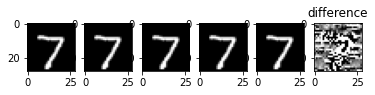

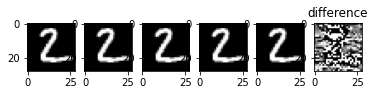

In [ ]:
print("Non targeted:Classifier 1")
display(Class1)

Non targeted:Classifier 2


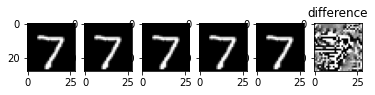

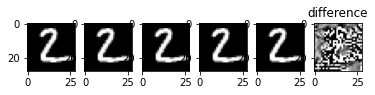

In [ ]:
print("Non targeted:Classifier 2")
display(Class2)

Non targeted:Classifier 3


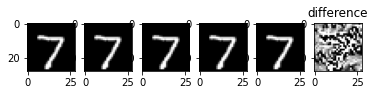

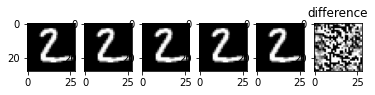

In [ ]:
print("Non targeted:Classifier 3")
display(Class3)

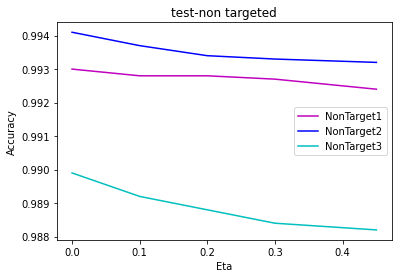

In [ ]:
plt.plot(eta,NonTarget1, color='m',label='NonTarget1')
plt.plot(eta,NonTarget2, color='b',label='NonTarget2')
plt.plot(eta,NonTarget3, color='c',label='NonTarget3')
plt.xlabel('Eta')
plt.ylabel('Accuracy')
plt.title('test-non targeted')
plt.legend()
plt.show()

**Targetted**

targeted:Classifier 1


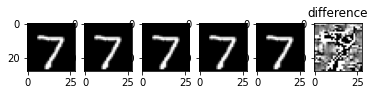

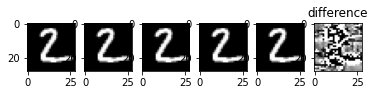

In [ ]:
print("targeted:Classifier 1")
display(TClass1)

targeted:Classifier 2


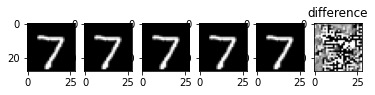

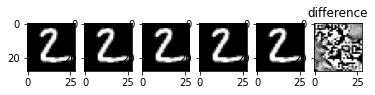

In [ ]:
print("targeted:Classifier 2")
display(TClass2)

targeted:Classifier 3


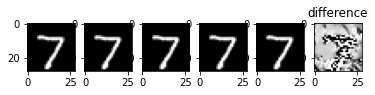

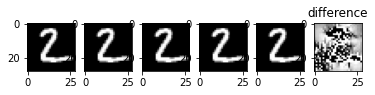

In [ ]:
print("targeted:Classifier 3")
display(TClass3)

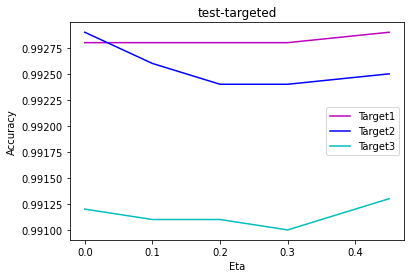

In [129]:
plt.plot(eta,Target1, color='m',label='Target1')
plt.plot(eta,Target2, color='b',label='Target2')
plt.plot(eta,Target3, color='c',label='Target3')
plt.xlabel('Eta')
plt.ylabel('Accuracy')
plt.title('test-targeted')
plt.legend()
plt.show()